## Voting Classifier
#### The idea of a voting classifier is that we can give it a list of estimators and we can also give it a weightf for each estimator, which can make us say we want this estimator to be weighted twice as heavily as another. The nice thing about this is that we can use this weight in our grid search i.e we can let the grid search determine the best weight to balance different models for our dataset

In [2]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

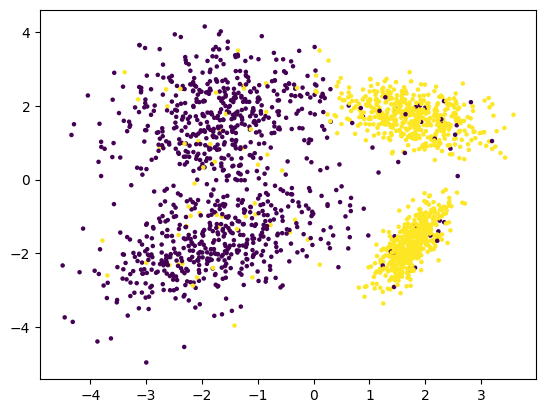

In [3]:
X, y = make_classification(n_samples=2000, n_features=2, n_redundant=0, random_state=21, class_sep=1.75, flip_y=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [4]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
# Soft voting means we are averaging the soft proba values
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                       voting='soft',
                       weights=[0.5, 0.5])
clf3.fit(X, y)

VotingClassifier(estimators=[('clf1', LogisticRegression()),
                             ('clf2', KNeighborsClassifier(n_neighbors=10))],
                 voting='soft', weights=[0.5, 0.5])

### From the above grid, although the VoitingClassifier is our final model, but it gives us the chance to be able to use other models as paraeters and give them certain weights that enhance how much the final model depends on this other models

## Trying with another dataset

In [22]:
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklego.meta import Thresholder
import pandas as pd

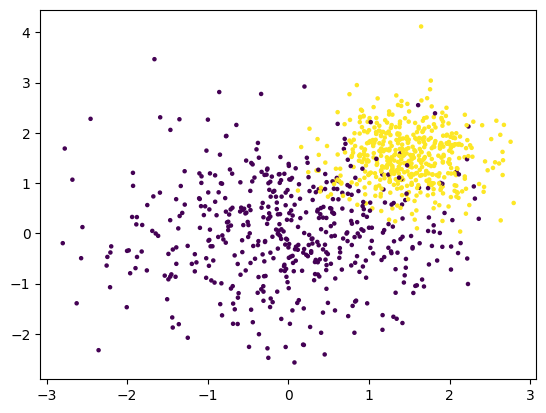

In [7]:
X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

### Imagine we use logistic regression on the abovw data, we would ahve a line in btw where we start getting a lot of yellow points. For this point, the threshold of the probability is 0.5 i.e where we determine if it belongs to a particular class or not. but what if we shift this threshold to about 0.7, our logistic regression line shifts a bit upward and then when we try to predict it is yellow, we are much more sure. of course, this would have consequences on our model

### Thresholder accepts any scikit learn model but it only works in binary classification ccases, so wew can set the thresholder which is something we can do in our grid search

In [8]:
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

### the threshold 0.1 would give us a great recall but bad precision jbut the threshold 0.9 woulg give us a great precision but bad recall

In [15]:
pipe = Pipeline([
    ('model', Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])
mod = GridSearchCV(estimator=pipe,
                  param_grid = {'model__threshold': np.linspace(0.1, 0.9, 50)},
                  scoring={'precision': make_scorer(precision_score),
                          'recall': make_scorer(recall_score),
                          'accuracy': make_scorer(accuracy_score)},
                  refit='precision',
                  cv=5)
mod.fit(X, y);

### Let us consider a time series task

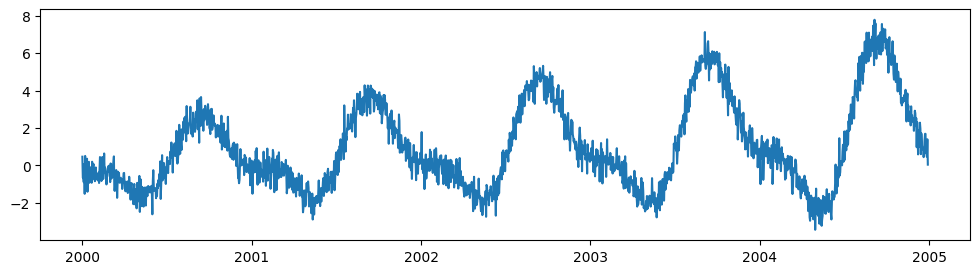

In [28]:
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.datasets import make_simpleseries
from sklearn.dummy import DummyRegressor

yt = make_simpleseries(seed=1)
dates = pd.date_range('2000-01-01', periods=len(yt))
df = (pd.DataFrame({'yt': yt,
                   'date': dates})
     .assign(m=lambda d: d.date.dt.month)
     .reset_index())
plt.figure(figsize=(12, 3))
plt.plot(dates, make_simpleseries(seed=1))

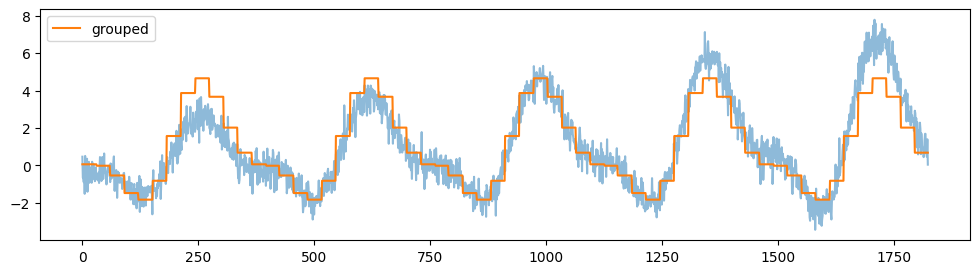

In [30]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=['m'])
       .fit(df[['m']], df['yt']))
plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label='grouped')
plt.legend();

### We can notice the oveshooting in the past years and the under shooting in recent years, we can enhance our datato fucs more either on the past or teh future years, to enhance our prediction. We can make use of the  decay parameter

In [36]:
# Before using the decay estimator, our data points needs to be sorted before hand
mod2 = (GroupedPredictor(DecayEstimator(DummyRegressor(), decay=0.9), groups=['m'])
                        .fit(df[['index', 'm']], df['yt']))

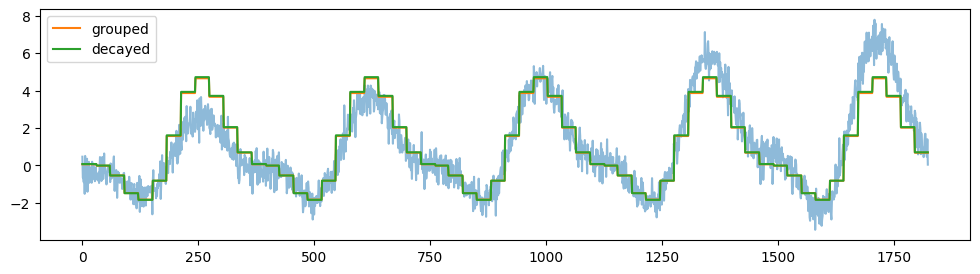

In [37]:
plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label='grouped')
plt.plot(mod2.predict(df[['index', 'm']]), label='decayed')
plt.legend();